# Capstone Project - Battle of Neighborhoods

![title](kolkata.jpg)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

### Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **restaurant** in **Kolkata, West Bengal, India**.

Since there are lots of restaurants in Kolkata we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with no restaurants in vicinity**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

### Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* distance to restaurants in the neighborhood, if any
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **geopy reverse geocoding**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Kolkata center will be obtained using **geopy geocoding** of well known Kolkata location (Rabindra Sadan/ Park Street/ Esplanade)

### Neighborhood Allocation

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 12x12 kilometers centered around Kolkata city center.

Let's first find the latitude & longitude of Kolkata city center, using specific, well known address and geopy client for several popular geocoding web services.

In [266]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Park Street, Kolkata'
kolkata_center = []
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
kolkata_center.append(location.latitude)
kolkata_center.append(location.longitude)
print('Coordinate of {}: {}'.format(address, kolkata_center))

Coordinate of Park Street, Kolkata: [22.5551591, 88.3501171]


In [267]:
import folium # map rendering library

map_kolkata = folium.Map(location=kolkata_center, zoom_start=15)
folium.Marker(kolkata_center, popup=address).add_to(map_kolkata)
map_kolkata

Now let's create a grid of area candidates, equaly spaced, centered around city center and within __~8 km__ from __Park Street, Kolkata__. Our neighborhoods will be defined as circular areas with a radius of __400 meters__, so our neighborhood centers will be __1500 meters__ i.e. __1.5 km__ apart.

To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).

In [268]:
import shapely.geometry
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Kolkata center longitude = {}, latitude = {}'.format(kolkata_center[1], kolkata_center[0]))
x, y = lonlat_to_xy(kolkata_center[1], kolkata_center[0])
print('Kolkata center UTM X = {}, Y = {}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Kolkata center longitude = {}, latitude = {}'.format(lo, la))

Coordinate transformation check
-------------------------------
Kolkata center longitude = 88.3501171, latitude = 22.5551591
Kolkata center UTM X = 9404196.228467971, Y = 6175238.625252281
Kolkata center longitude = 88.35011709980317, latitude = 22.55515909996284


Let's create a **hexagonal grid of cells**: we offset every other row, and adjust vertical row spacing so that **every cell center is equally distant from all it's neighbors**.

In [269]:
kolkata_center_x, kolkata_center_y = lonlat_to_xy(kolkata_center[1], kolkata_center[0]) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = kolkata_center_x - 8000
x_step = 1500
y_min = kolkata_center_y - 8000 - (int(21/k)*k*1500 - 16000)/2
y_step = 1500 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 400 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(kolkata_center_x, kolkata_center_y, x, y)
        if (distance_from_center <= 6001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

58 candidate neighborhood centers generated.


In [270]:
map_kolkata = folium.Map(location=kolkata_center, zoom_start=13)
folium.Marker(kolkata_center, popup=address).add_to(map_kolkata)

for lat, lon in zip(latitudes, longitudes):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_kolkata)
    folium.Circle([lat, lon], radius=400, color='red', fill=False).add_to(map_kolkata)
    #folium.Marker([lat, lon]).add_to(map_kolkata)

map_kolkata

#### Tranform the data into a *pandas* dataframe

In [271]:
import pandas as pd

# define the dataframe columns
column_names = ['Address', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods

,Address,Latitude,Longitude


In [275]:
locator = Nominatim(user_agent="myGeocoder")

for i in range(len(latitudes)):
 
    neighborhood_lat = latitudes[i]
    neighborhood_lon = longitudes[i]
    
    coordinates = str(latitudes[i]) +', ' + str(longitudes[i])
    location = locator.reverse(coordinates)
    print(i,location[0])
    neighborhoods = neighborhoods.append({'Address': location[0],
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Address,Latitude,Longitude
0,"Hastings Post Office (Secondary), Bakery Road,...",22.547202,88.326939
1,"Strand Road, Hastings, Kolkata, West Bengal, 7...",22.542173,88.331082
2,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224
3,"Sashi Sehkar Bose Row, Bhawanipur, Kolkata, We...",22.532118,88.339364
4,"Vidyasagar Setu, Hastings, Kolkata, West Benga...",22.556906,88.326381


In [274]:
# neighborhoods.to_csv('neighborhood.csv')
neighborhoods = pd.read_csv('neighborhood.csv')
neighborhoods.drop(['Unnamed: 0'], axis=1, inplace=True)
neighborhoods.head()

,Address,Latitude,Longitude
0,"Hastings Post Office (Secondary), Bakery Road,...",22.547202,88.326939
1,"Strand Road, Hastings, Kolkata, West Bengal, 7...",22.542173,88.331082
2,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224
3,"Sashi Sehkar Bose Row, Bhawanipur, Kolkata, We...",22.532118,88.339364
4,"Vidyasagar Setu, Hastings, Kolkata, West Benga...",22.556906,88.326381


### Define Foursquare Credentials and Version

In [ ]:
CLIENT_ID = 'T3EQLFGGK20OUDAGY0CXX4TFUZLAGPYR3CQGY1T2OCW43WGJ' # your Foursquare ID
CLIENT_SECRET = 'J3V1Y3MN1JCKYI0IJ1YUJW1AMCMGWZOI3M4305VNYIXL3Q3X' # your Foursquare Secret
VERSION = '20190605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

### 1. Explore the neighbourhoods of Kolkata

In [ ]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

def getNearbyVenues(names, latitudes, longitudes, radius=400, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
kolkata_venues = getNearbyVenues(names=neighborhoods['Address'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

### 2. Exploratory Data Analysis

In [ ]:
print(kolkata_venues.shape)
# kolkata_venues.rename(columns={"Neighborhood": "Address"}, inplace=True)
kolkata_venues.head()

##### No. of unique categories can be curated from all the returned venues

In [ ]:
print('There are {} uniques categories.'.format(len(kolkata_venues['Venue Category'].unique())))

- Check for the unique values obtained for __Venue Category__ 

In [ ]:
kolkata_venues['Venue Category'].unique()

In [329]:
# kolkata_venues.to_csv('kolkata_venues.csv')
kolkata_venues = pd.read_csv('kolkata_venues.csv')
kolkata_venues.drop(['Unnamed: 0'], axis=1, inplace=True)

Selecting the relevant __'venue category'__ i.e. the categories that correspong to Restaurant, Cafe, Hotel etc.

In [330]:
req_category = ['Fast Food Restaurant', 'Hotel', 'Indian Restaurant', 'Chinese Restaurant',
       'Italian Restaurant', 'Mediterranean Restaurant', 'Dhaba', 'Food Truck', 'Food Court', 'Bengali Restaurant', 
       'American Restaurant', 'Restaurant', 'Asian Restaurant', 'South Indian Restaurant',
       'Mexican Restaurant', 'Theme Restaurant', 'Sandwich Place', 'Pizza Place', 'Japanese Restaurant', 'BBQ Joint',
       'Snack Place', 'Steakhouse', 'Mughlai Restaurant', 'Tex-Mex Restaurant', 'Vegetarian / Vegan Restaurant',
       'Thai Restaurant', 'Dumpling Restaurant']

In [331]:
# dropping the instances with irrelevant 'venue category'
drop_index = []
for i in range(len(kolkata_venues['Venue Category'])):
    if kolkata_venues.loc[i]['Venue Category'] not in req_category:
        drop_index.append(i)
        

kolkata_venues.drop(index=drop_index, inplace=True)
kolkata_venues.reset_index(drop=True, inplace=True)
kolkata_venues.head()

,Address,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Strand Road, Hastings, Kolkata, West Bengal, 7...",22.542173,88.331082,Panchu Babu's Shop,22.540976,88.328224,Fast Food Restaurant
1,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,Taj Bengal,22.537459,88.334066,Hotel
2,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,Sonargaon,22.537545,88.334210,Indian Restaurant
3,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,Chinoiserie,22.537733,88.334327,Chinese Restaurant
4,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,The Hub,22.537879,88.334498,Italian Restaurant


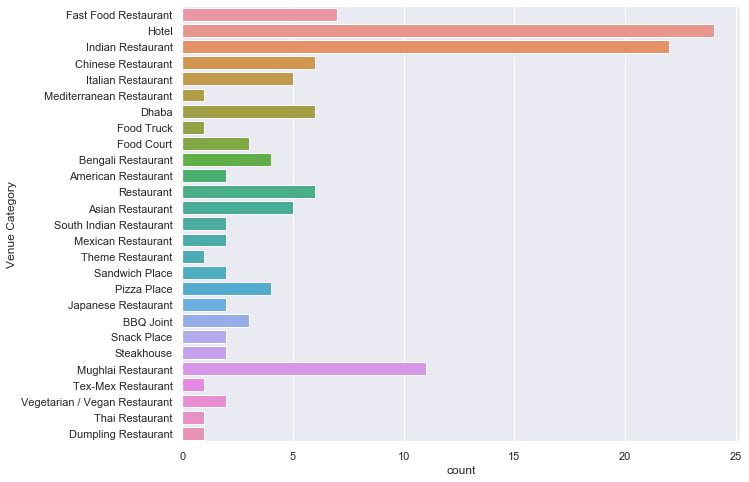

In [332]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax = sns.countplot(y="Venue Category", data=kolkata_venues)

From the countplot we can infer that in the ~8 km radius around Park Street, Kolkata there are __>20 Hotels & Indian Restaurants__ and __>10 Mughlai Restaurants__. All other types of restaurants are <10 i.e. very less in number and quite sparsely located.

In [333]:
print('Average number of Restaurants around a neighborhood: ', kolkata_venues.groupby(['Address'])['Venue Category'].count().mean())

Average number of Restaurants around a neighborhood:  4.413793103448276


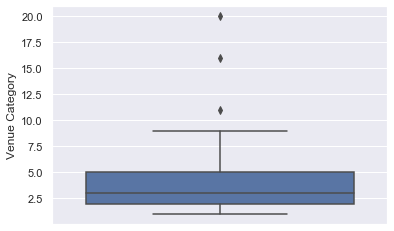

In [334]:
ax = sns.boxplot(y=kolkata_venues.groupby(['Address'])['Venue Category'].count(), data=kolkata_venues)

In [335]:
map_kolkata = folium.Map(location=kolkata_center, zoom_start=13)
folium.Marker(kolkata_center, popup=address).add_to(map_kolkata)
for i in range(len(kolkata_venues['Venue'])):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_kolkata)
    folium.Circle([kolkata_venues.loc[i]['Neighborhood Latitude'], kolkata_venues.loc[i]['Neighborhood Longitude']], radius=400, color='red', fill=False).add_to(map_kolkata)
    folium.Marker([kolkata_venues.loc[i]['Venue Latitude'], kolkata_venues.loc[i]['Venue Longitude']],
                  popup=kolkata_venues.loc[i]['Venue']).add_to(map_kolkata)

map_kolkata

Looking good. So now we have all the restaurants in area within few kilometers from __Park Street, Kolkata__! We also know which restaurants exactly are in vicinity of every neighborhood candidate center.

We also infer that certain randomly chosen neighborhoods do not have any restaurant or eateries in their locality. This is due to variety of reasons:
- Few neighborhoods were selected on the River Ganga
- Few of them also inluded __Fort William, Kolkata__ which is the Indian Army HQs.
- Some of them falls around the railway lines etc.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new restaurant!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Berlin that have low restaurant density, particularly those with low number of restaurants. We will limit our analysis to area ~8 km around city center.

In first step we have collected the required **data: location and type (category) of every restaurant within 8km from Kolkata city center** (Park Street). We have also **identified restaurants** around each neighborhood.

In second and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations with 
- **no more than two restaurants in radius of 250 meters**.

We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which would help the stakeholders in further decsion making.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of restaurants in every area candidate**:

In [336]:
df = pd.DataFrame(kolkata_venues.groupby(['Address', 'Venue Category']).count()['Venue'])
df.head(25)

Venue
Address                                            Venue Category                      
20, Camac Street, Mallick Bazaar, Ho Chi Min Sa... Hotel                              3
                                                   Indian Restaurant                  3
                                                   Restaurant                         1
                                                   Sandwich Place                     1
                                                   Theme Restaurant                   1
Ananda, Chittaranjan Avenue, Central Avenue 2, ... Hotel                              1
                                                   Indian Restaurant                  1
                                                   Mughlai Restaurant                 1
                                                   South Indian Restaurant            1
Ballygunj Military Campus, Lovelock Street, Mal... Dhaba                              1
Beninandan Street, Mallick Bazaar, Bhawanipur, ... Dhaba                              1
                                                   Fast Food Restaurant               2
Bhoruka Research Centre for Haematology and Blo... Asian Restaurant                   1
                                                   Hotel                              2
                                                   Mughlai Restaurant                 1
Bright Street, Mallick Bazaar, Beniapukur, Kolk... Indian Restaurant                  1
                                                   Vegetarian / Vegan Restaurant      1
Christopher Rd, Mallick Bazaar, Tangra North, K... Chinese Restaurant                 1
Colootola Street, Central Avenue 2, Kolkata, We... Indian Restaurant                  2
                                                   Vegetarian / Vegan Restaurant      1
Doctor Lane, Mallick Bazaar, Tal Tala, Kolkata,... Hotel                              1
Esplanade, Esplanade Row East, Esplanade, Kolka... Hotel                              2
                                                   Indian Restaurant                  1
Farsight Eye Research Centre, Lower Range, Mall... Chinese Restaurant                 1
                                                   Indian Restaurant                  1

In [337]:
# defining a function to calculate distance of each restaurant from the center of neighborhood

def cal_dist_center(center_lat, center_long, venue_lat, venue_lon):
    center_x, center_y = lonlat_to_xy(center_lat, center_long)
    venue_x, venue_y = lonlat_to_xy(venue_lat, venue_lon)
    dist = calc_xy_distance(center_x, center_y, venue_x, venue_y)
    return dist

In [338]:
distance = []
for i in range(len(kolkata_venues['Venue'])):
    d = cal_dist_center(kolkata_venues.loc[i]['Neighborhood Latitude'], kolkata_venues.loc[i]['Neighborhood Longitude'],
                       kolkata_venues.loc[i]['Venue Latitude'], kolkata_venues.loc[i]['Venue Longitude'])
    distance.append(d)

In [339]:
kolkata_venues['Distance Neighborhood'] = distance
kolkata_venues.head()

,Address,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance Neighborhood
0,"Strand Road, Hastings, Kolkata, West Bengal, 7...",22.542173,88.331082,Panchu Babu's Shop,22.540976,88.328224,Fast Food Restaurant,319.113487
1,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,Taj Bengal,22.537459,88.334066,Hotel,129.320472
2,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,Sonargaon,22.537545,88.334210,Indian Restaurant,113.193833
3,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,Chinoiserie,22.537733,88.334327,Chinese Restaurant,100.175214
4,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,The Hub,22.537879,88.334498,Italian Restaurant,81.104265


In [340]:
print('Average distance to closest restaurant from each area center:', kolkata_venues['Distance Neighborhood'].mean(), "metres")

Average distance to closest restaurant from each area center: 178.78068726930698 metres


In [341]:
print('Maximum distance to closes restaurant from each area center:', kolkata_venues['Distance Neighborhood'].max(), "metres")

Maximum distance to closes restaurant from each area center: 425.3135645682075 metres


OK, so **on average restaurant can be found within ~200m and maximum of ~450m** from every area center candidate.

In [342]:
kolkata_venues.groupby(['Address'])['Venue'].count().unique()

array([ 9,  4,  1,  3,  2,  5,  6, 11, 20, 16], dtype=int64)

Selecting areas with __<10 restaurants__ in their vicinity

In [343]:
kolkata_venues.groupby(['Address'])['Venue'].count()

address1= 'Mi Home, Camac Street, Mallick Bazaar, Ho Chi Min Sarani, Kolkata, West Bengal, 700016, India'
address2 = 'New Market, Market St, Mallick Bazaar, New Market, Kolkata, West Bengal, 700087, India'
address3 = 'Mallick Bazaar, Ho Chi Min Sarani, Kolkata, West Bengal, 700020, India'

In [344]:
kolkata_venues = kolkata_venues.loc[kolkata_venues['Address'] != address1]
kolkata_venues = kolkata_venues.loc[kolkata_venues['Address'] != address2]
kolkata_venues = kolkata_venues.loc[kolkata_venues['Address'] != address3]
kolkata_venues.reset_index(drop=True, inplace=True)
kolkata_venues.shape

(81, 8)

In [345]:
print('Approximate number of locations with low restaurant count: ', kolkata_venues.Address.nunique())

Approximate number of locations with low restaurant count:  26


In [346]:
# one hot encoding
kolkata_onehot = pd.get_dummies(kolkata_venues[['Venue Category']], prefix="", prefix_sep="")

# add address column back to dataframe
kolkata_onehot['Address'] = kolkata_venues['Address'] 

# move address column to the first column
fixed_columns = [kolkata_onehot.columns[-1]] + list(kolkata_onehot.columns[:-1])
kolkata_onehot = kolkata_onehot[fixed_columns]

kolkata_onehot.head()

,Address,Asian Restaurant,BBQ Joint,Bengali Restaurant,Chinese Restaurant,Dhaba,Fast Food Restaurant,Food Court,Food Truck,Hotel,...,Mughlai Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Steakhouse,Tex-Mex Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
0,"Strand Road, Hastings, Kolkata, West Bengal, 7...",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [347]:
kolkata_onehot.shape

(81, 25)

##### Next, let's group rows by address and by taking the mean of the frequency of occurrence of each category

In [348]:
kolkata_grouped = kolkata_onehot.groupby('Address').mean().reset_index()
kolkata_grouped

,Address,Asian Restaurant,BBQ Joint,Bengali Restaurant,Chinese Restaurant,Dhaba,Fast Food Restaurant,Food Court,Food Truck,Hotel,...,Mughlai Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Steakhouse,Tex-Mex Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
0,"20, Camac Street, Mallick Bazaar, Ho Chi Min S...",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.333333,...,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.0,0.111111,0.000000
1,"Ananda, Chittaranjan Avenue, Central Avenue 2,...",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.250000,...,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.0,0.000000,0.000000
2,"Ballygunj Military Campus, Lovelock Street, Ma...",0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,"Beninandan Street, Mallick Bazaar, Bhawanipur,...",0.000000,0.000000,0.000000,0.0,0.333333,0.666667,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,Bhoruka Research Centre for Haematology and Bl...,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.500000,...,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,"Bright Street, Mallick Bazaar, Beniapukur, Kol...",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.500000
6,"Christopher Rd, Mallick Bazaar, Tangra North, ...",0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,"Colootola Street, Central Avenue 2, Kolkata, W...",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333
8,"Doctor Lane, Mallick Bazaar, Tal Tala, Kolkata...",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,"Esplanade, Esplanade Row East, Esplanade, Kolk...",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


##### Let's print each address with the top 5 most common venues

In [349]:
num_top_venues = 5

for hood in kolkata_grouped['Address']:
    print("----"+hood+"----")
    temp = kolkata_grouped[kolkata_grouped['Address'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----20, Camac Street, Mallick Bazaar, Ho Chi Min Sarani, Kolkata, West Bengal, 700020, India----
               venue  freq
0              Hotel  0.33
1  Indian Restaurant  0.33
2   Theme Restaurant  0.11
3     Sandwich Place  0.11
4         Restaurant  0.11


----Ananda, Chittaranjan Avenue, Central Avenue 2, Kolkata, West Bengal, 700012, India----
                     venue  freq
0  South Indian Restaurant  0.25
1                    Hotel  0.25
2        Indian Restaurant  0.25
3       Mughlai Restaurant  0.25
4         Asian Restaurant  0.00


----Ballygunj Military Campus, Lovelock Street, Mallick Bazaar, Hazra, Kolkata, West Bengal, 700 025, India----
                venue  freq
0               Dhaba   1.0
1    Asian Restaurant   0.0
2  Mexican Restaurant   0.0
3    Theme Restaurant   0.0
4  Tex-Mex Restaurant   0.0


----Beninandan Street, Mallick Bazaar, Bhawanipur, Kolkata, West Bengal, 700020, India----
                  venue  freq
0  Fast Food Restaurant  0.67
1              

We observe that not all areas have 5 top venues around them because many of them has frequency 0.00

#### Let's put that into a *pandas* dataframe
First, let's write a function to sort the venues in descending order.

In [350]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [351]:
import numpy as np

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Address']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Address'] = kolkata_grouped['Address']

for ind in np.arange(kolkata_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kolkata_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"20, Camac Street, Mallick Bazaar, Ho Chi Min S...",Indian Restaurant,Hotel,Sandwich Place
1,"Ananda, Chittaranjan Avenue, Central Avenue 2,...",South Indian Restaurant,Mughlai Restaurant,Hotel
2,"Ballygunj Military Campus, Lovelock Street, Ma...",Dhaba,Vegetarian / Vegan Restaurant,Theme Restaurant
3,"Beninandan Street, Mallick Bazaar, Bhawanipur,...",Fast Food Restaurant,Dhaba,Vegetarian / Vegan Restaurant
4,Bhoruka Research Centre for Haematology and Bl...,Hotel,Asian Restaurant,Mughlai Restaurant


### Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [352]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kolkata_grouped_clustering = kolkata_grouped.drop('Address', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kolkata_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 4, 3, 2, 1, 1, 1, 2, 2])

Let's create a new dataframe that includes the cluster as well as the top 3 venues for each neighborhood.

In [353]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kolkata_merged = kolkata_venues
kolkata_merged = kolkata_merged.join(neighborhoods_venues_sorted.set_index('Address'), on='Address')

kolkata_merged.head()

,Address,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"Strand Road, Hastings, Kolkata, West Bengal, 7...",22.542173,88.331082,Panchu Babu's Shop,22.540976,88.328224,Fast Food Restaurant,319.113487,3,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Theme Restaurant
1,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,Taj Bengal,22.537459,88.334066,Hotel,129.320472,1,Italian Restaurant,Chinese Restaurant,Hotel
2,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,Sonargaon,22.537545,88.334210,Indian Restaurant,113.193833,1,Italian Restaurant,Chinese Restaurant,Hotel
3,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,Chinoiserie,22.537733,88.334327,Chinese Restaurant,100.175214,1,Italian Restaurant,Chinese Restaurant,Hotel
4,"Taj Bengal, Belvedere Road, Alipore, Kolkata, ...",22.537145,88.335224,The Hub,22.537879,88.334498,Italian Restaurant,81.104265,1,Italian Restaurant,Chinese Restaurant,Hotel


Finally, let's visualize the resulting clusters

In [359]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=kolkata_center, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kolkata_merged['Venue Latitude'], kolkata_merged['Venue Longitude'], kolkata_merged['Cluster Labels'], kolkata_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Visualizing the clusters

Cluster 1

In [365]:
kolkata_merged.loc[kolkata_merged['Cluster Labels'] == 0, kolkata_merged.columns[[1] + list(range(5, kolkata_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Distance Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
9,22.548835,88.339869,Food Truck,66.098239,0,Food Truck,Vegetarian / Vegan Restaurant,Theme Restaurant


Cluster 2

In [367]:
kolkata_merged.loc[kolkata_merged['Cluster Labels'] == 1, kolkata_merged.columns[[1] + list(range(5, kolkata_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Distance Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,22.537145,88.334066,Hotel,129.320472,1,Italian Restaurant,Chinese Restaurant,Hotel
2,22.537145,88.334210,Indian Restaurant,113.193833,1,Italian Restaurant,Chinese Restaurant,Hotel
3,22.537145,88.334327,Chinese Restaurant,100.175214,1,Italian Restaurant,Chinese Restaurant,Hotel
4,22.537145,88.334498,Italian Restaurant,81.104265,1,Italian Restaurant,Chinese Restaurant,Hotel
5,22.537145,88.334241,Mediterranean Restaurant,109.758777,1,Italian Restaurant,Chinese Restaurant,Hotel
...,...,...,...,...,...,...,...,...
76,22.552085,88.363881,Indian Restaurant,403.597962,1,Mughlai Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant
77,22.576889,88.355538,Vegetarian / Vegan Restaurant,110.992094,1,Indian Restaurant,Vegetarian / Vegan Restaurant,Theme Restaurant
78,22.576889,88.356653,Indian Restaurant,235.668748,1,Indian Restaurant,Vegetarian / Vegan Restaurant,Theme Restaurant
79,22.576889,88.357136,Indian Restaurant,289.504131,1,Indian Restaurant,Vegetarian / Vegan Restaurant,Theme Restaurant


Cluster 3

In [368]:
kolkata_merged.loc[kolkata_merged['Cluster Labels'] == 2, kolkata_merged.columns[[1] + list(range(5, kolkata_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Distance Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
55,22.570232,88.341869,Hotel,366.635406,2,Hotel,Vegetarian / Vegan Restaurant,Theme Restaurant
56,22.565198,88.350010,Hotel,80.668518,2,Hotel,Indian Restaurant,Vegetarian / Vegan Restaurant
57,22.565198,88.351847,Indian Restaurant,285.366357,2,Hotel,Indian Restaurant,Vegetarian / Vegan Restaurant
58,22.565198,88.351459,Hotel,242.165902,2,Hotel,Indian Restaurant,Vegetarian / Vegan Restaurant
59,22.555132,88.354063,Mughlai Restaurant,391.170384,2,Hotel,Asian Restaurant,Mughlai Restaurant
60,22.555132,88.354867,Asian Restaurant,301.465725,2,Hotel,Asian Restaurant,Mughlai Restaurant
61,22.555132,88.354694,Hotel,320.805765,2,Hotel,Asian Restaurant,Mughlai Restaurant
62,22.555132,88.357329,Hotel,26.667849,2,Hotel,Asian Restaurant,Mughlai Restaurant
73,22.562150,88.361805,Hotel,288.056986,2,Hotel,Vegetarian / Vegan Restaurant,Theme Restaurant
74,22.557117,88.361805,Hotel,173.961355,2,Hotel,Vegetarian / Vegan Restaurant,Theme Restaurant


Cluster 4

In [369]:
kolkata_merged.loc[kolkata_merged['Cluster Labels'] == 3, kolkata_merged.columns[[1] + list(range(5, kolkata_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Distance Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,22.542173,88.328224,Fast Food Restaurant,319.113487,3,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Theme Restaurant
6,22.536789,88.344220,Dhaba,142.138013,3,Fast Food Restaurant,Dhaba,Vegetarian / Vegan Restaurant
7,22.536789,88.344228,Fast Food Restaurant,143.040208,3,Fast Food Restaurant,Dhaba,Vegetarian / Vegan Restaurant
8,22.536789,88.346353,Fast Food Restaurant,380.238996,3,Fast Food Restaurant,Dhaba,Vegetarian / Vegan Restaurant


Cluster 5

In [372]:
kolkata_merged.loc[kolkata_merged['Cluster Labels'] == 4, kolkata_merged.columns[[1] + list(range(5, kolkata_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Distance Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
35,22.53339,88.356786,Dhaba,425.313565,4,Dhaba,Vegetarian / Vegan Restaurant,Theme Restaurant


In [377]:
kolkata_merged.groupby(['Cluster Labels'])['1st Most Common Venue'].unique()[1]

array(['Italian Restaurant', 'Food Court', 'Bengali Restaurant',
       'Asian Restaurant', 'Indian Restaurant', 'Chinese Restaurant',
       'Mughlai Restaurant', 'Vegetarian / Vegan Restaurant',
       'South Indian Restaurant'], dtype=object)

## Results and Discussion <a name="results"></a>

Therefore from whatever limited data available, we could successfully identify 26 zones where the number of restaurants were less than 10 in their vicinity. Most of them had restaurant count even less than 5 in 400 m surroundings. What we observe is that Kolkata is comparatively less restaurant density. More data could have helped us to understand our regions in a much better manner.

Those location candidates were then clustered to create zones of interest which contain greatest number of location candidates. It was found that cluster 2 has 80% of the venues grouped together. Further observations reveal that 'Italian Restaurant', 'Bengali Restaurant', 'Asian Restaurant', 'Indian Restaurant', 'Chinese Restaurant', 'Mughlai Restaurant', 'South Indian Restaurant' are the most common types of restaurants. Hence the stakeholders can try setting up restaurants of diffrent cultures other than the already present common ones.

Result of all this is 26 zones containing largest number of potential new restaurant locations based on number of and distance to existing venues - both restaurants in general. This, of course, does not imply that those zones are actually optimal locations for a new restaurant! Purpose of this analysis was to only provide info on areas close to Kolkata center but not crowded with existing restaurants (particularly Italian) - it is entirely possible that there is a very good reason for small number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Kolkata areas close to center with low number of restaurants in order to aid stakeholders in narrowing down the search for optimal location for a new restaurant. By calculating restaurant density distribution from Foursquare data we have first identified general addresses that justify further analysis and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurants. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.